# Jaccard index implementation comparison

This is an attempt to compare two different methods of calculating the Jaccard index (direct set operations vs. iterating over underlying hashes/elements and counting to avoid some of the set operations).

In [54]:
import random
import pprint

num_hashes = 10
max_hash = 100
num_samples = 10
timing_repeats = 5
timing_iterations = 1000

def build_sample_hashes(num_samples, num_hashes, max_hash):
    random.seed(42)

    sample_hashes = {}
    for sample in range(num_samples):
        sample_hashes[sample] = set(random.sample(range(max_hash), num_hashes))
    return sample_hashes

def build_hash_samples(sample_hashes):
    hash_samples = {}

    for s in sample_hashes:
        for h in sample_hashes[s]:
            if h not in hash_samples:
                hash_samples[h] = {s}
            else:
                hash_samples[h].add(s)
    return hash_samples

def build_data_structures(num_samples, num_hashes, max_hash):
    sample_hashes = build_sample_hashes(num_samples=num_samples, num_hashes=num_hashes, max_hash=max_hash)
    hash_samples = build_hash_samples(sample_hashes)
    
    return {
        'sample_hashes': sample_hashes,
        'hash_samples': hash_samples
    }

# Build small data structure to show what it does
pprint.pprint(build_data_structures(num_samples=5, num_hashes=10, max_hash=max_hash))

# Build larger data structure to test below functions
data_structures = build_data_structures(num_samples=num_samples, num_hashes=num_hashes, max_hash=max_hash)

{'hash_samples': {0: {3},
                  3: {0, 1, 2},
                  4: {1},
                  11: {1, 4},
                  12: {4},
                  13: {0, 4},
                  14: {0},
                  17: {0},
                  19: {3},
                  20: {3},
                  25: {2},
                  27: {1, 4},
                  28: {0, 2},
                  29: {1},
                  31: {0},
                  35: {0, 3},
                  43: {3, 4},
                  44: {4},
                  45: {4},
                  48: {4},
                  53: {2},
                  54: {1, 3},
                  57: {3},
                  64: {1},
                  69: {1, 2},
                  71: {2},
                  75: {1, 3},
                  77: {2, 4},
                  81: {0},
                  83: {2},
                  86: {0},
                  89: {2, 3},
                  91: {2},
                  94: {0, 1},
                  97: {3, 4}},
 'sample_has

Here, we have two data structures representing the same data:

1. `sample_hashes`: maps a sample (identified numerically starting from the 0th sample) to a set of hashes
    1. That is the data structure is like `{'sample_id' => set of hashes}`
2. `hash_samples`: maps a hash to a set of samples containing this hash.
    1. That is the data structure is like `{'hash' => set of samples}`

My goal is to test two different methods to measure the Jaccard distance using these two data structures to see how they perform.

Below I implement a wrapper to wrap functions with arguments for `timeit` (see https://www.pythoncentral.io/time-a-python-function/) and generate some stats for plotting.

In [57]:
import timeit
from statistics import mean, stdev, median, quantiles

def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

def stats(values):
    return {
        'mean': mean(values),
        'median': median(values),
        'stdev': stdev(values)
    }

def do_timing(func, iterations, repeat, label):
    results = func()
    return_table = stats(timeit.repeat(func, number=iterations, repeat=repeat))
    return_table['results'] = results
    return_table['label'] = label
    return return_table

test_wrapper = wrapper(mean, range(1,100))
do_timing(test_wrapper, iterations=100, repeat=5, label='test')

{'mean': 0.0053618799982359635,
 'median': 0.005118600005516782,
 'stdev': 0.0012791545951984554,
 'results': 50,
 'label': 'test'}

# Jaccard by iterating over samples

In [58]:
def regular_jaccard_index(query_sample, sample_hashes):
    jaccard_values = {}
    for s in sample_hashes:
        query_sample_hashes = sample_hashes[query_sample]
        comparison_sample_hashes = sample_hashes[s]

        jaccard = len(query_sample_hashes & comparison_sample_hashes) / len(query_sample_hashes | comparison_sample_hashes)
        jaccard_values[s] = jaccard
        
    return jaccard_values

regular_jaccard_index(query_sample=0, sample_hashes=data_structures['sample_hashes'])

{0: 1.0,
 1: 0.1111111111111111,
 2: 0.1111111111111111,
 3: 0.05263157894736842,
 4: 0.05263157894736842,
 5: 0.0,
 6: 0.0,
 7: 0.1111111111111111,
 8: 0.0,
 9: 0.1111111111111111}

# Jaccard index by iterating over hashes

In [61]:
def inverted_jaccard_index(query_sample, hash_samples, sample_hashes, num_samples, num_hashes):
    query_hashes = sample_hashes[query_sample]
    sample_hash_counts = {}
    for qh in query_hashes:
        for s in hash_samples[qh]:
            if s not in sample_hash_counts:
                sample_hash_counts[s] = 1
            else:
                sample_hash_counts[s] += 1
    jaccard_values = {}
    for s in range(0,num_samples):
        if s in sample_hash_counts:
            num_intersection = sample_hash_counts[s]
            jaccard_value = (num_intersection) / (2*num_hashes - num_intersection)
            jaccard_values[s] = jaccard_value
        else:
            jaccard_values[s] = 0
    return jaccard_values

inverted_jaccard_index(0, data_structures['hash_samples'], data_structures['sample_hashes'], num_samples, num_hashes)

{0: 1.0,
 1: 0.1111111111111111,
 2: 0.1111111111111111,
 3: 0.05263157894736842,
 4: 0.05263157894736842,
 5: 0,
 6: 0,
 7: 0.1111111111111111,
 8: 0,
 9: 0.1111111111111111}

# Comparison

Now, let's compare both methods.

In [64]:
import pandas as pd

def find_max_samples_sharing_hash(hash_samples):
    max_value = 0
    for h in hash_samples:
        num_samples = len(hash_samples[h])
        if num_samples > max_value:
            max_value = num_samples
    return max_value

def comparisons():
    max_hash = 10000
    query_sample = 0
    repeat = 3
    iterations = 100
    
    timing_results = []
    
    for num_hashes in [1000]:
#     for num_hashes in [1000, 2000, 3000]:
#         for num_samples in [100]:
        for num_samples in range(10,101,10):
            data_structures = build_data_structures(num_samples=num_samples, num_hashes=num_hashes, max_hash=max_hash)
            max_samples = find_max_samples_sharing_hash(data_structures['hash_samples'])

            regular_jaccard = wrapper(regular_jaccard_index, query_sample=query_sample, sample_hashes=data_structures['sample_hashes'])
            inverted_jaccard = wrapper(inverted_jaccard_index, query_sample=query_sample, hash_samples=data_structures['hash_samples'],
                                       sample_hashes=data_structures['sample_hashes'], num_samples=num_samples, num_hashes=num_hashes)

            regular_results = do_timing(regular_jaccard, iterations=iterations, repeat=repeat, label='Regular Jaccard Index')
            inverted_results = do_timing(inverted_jaccard, iterations=iterations, repeat=repeat, label='Inverted Jaccard Index')
            
            # Verifies that my results are identical in both implementations
            assert regular_results['results'] == inverted_results['results']

            # Now remove results from dictionary since I don't need them for plotting
            del regular_results['results']
            del inverted_results['results']

            regular_results['Number of Samples'] = num_samples
            inverted_results['Number of Samples'] = num_samples
            
            regular_results['Number of hashes'] = num_hashes
            inverted_results['Number of hashes'] = num_hashes
            
            regular_results['Max hash'] = max_hash
            inverted_results['Max hash'] = max_hash
            
            regular_results['Max samples sharing hash'] = max_samples
            inverted_results['Max samples sharing hash'] = max_samples

            timing_results.append(regular_results)
            timing_results.append(inverted_results)
    
    return pd.DataFrame(timing_results)
    
results_df = comparisons()
results_df

,mean,median,stdev,label,Number of Samples,Number of hashes,Max hash,Max samples sharing hash
0,0.084673,0.083729,0.014152,Regular Jaccard Index,10,1000,10000,5
1,0.021845,0.020385,0.004544,Inverted Jaccard Index,10,1000,10000,5
2,0.165503,0.168126,0.006334,Regular Jaccard Index,20,1000,10000,8
3,0.028003,0.026348,0.003961,Inverted Jaccard Index,20,1000,10000,8
4,0.237247,0.234371,0.018962,Regular Jaccard Index,30,1000,10000,10
5,0.051409,0.054354,0.008718,Inverted Jaccard Index,30,1000,10000,10
6,0.341104,0.338372,0.029748,Regular Jaccard Index,40,1000,10000,13
7,0.048249,0.048146,0.004797,Inverted Jaccard Index,40,1000,10000,13
8,0.408788,0.399902,0.017550,Regular Jaccard Index,50,1000,10000,14
9,0.065648,0.065226,0.003003,Inverted Jaccard Index,50,1000,10000,14


<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Number of hashes', ylabel='Runtime (seconds)'>

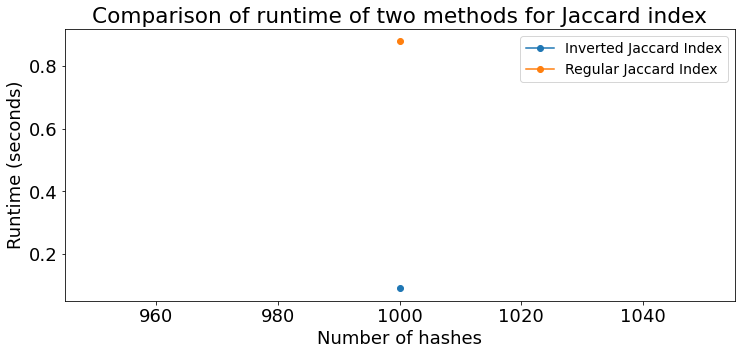

In [65]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 18,
    'legend.fontsize': 14
})

def make_plot(plotting_label, constant_label, constant_value):
    plot_df = results_df[results_df[constant_label] == constant_value]
    plot_df = plot_df[['mean', 'label', plotting_label]].set_index([plotting_label, 'label']).unstack(-1)
    plot_df.columns = plot_df.columns.droplevel()
    plot_df.columns.name = None

    axes = plot_df.plot(kind='line', figsize=(12,5), marker='o')
    axes.set_ylabel('Runtime (seconds)')
    axes.set_title('Comparison of runtime of two methods for Jaccard index')
    return axes

make_plot(plotting_label='Number of hashes', constant_label='Number of Samples', constant_value=100)

<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Number of Samples', ylabel='Runtime (seconds)'>

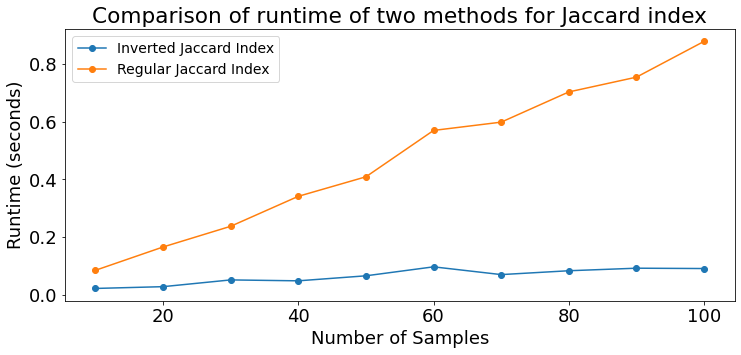

In [67]:
make_plot(plotting_label='Number of Samples', constant_label='Number of hashes', constant_value=1000)

<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Max samples sharing hash', ylabel='Runtime (seconds)'>

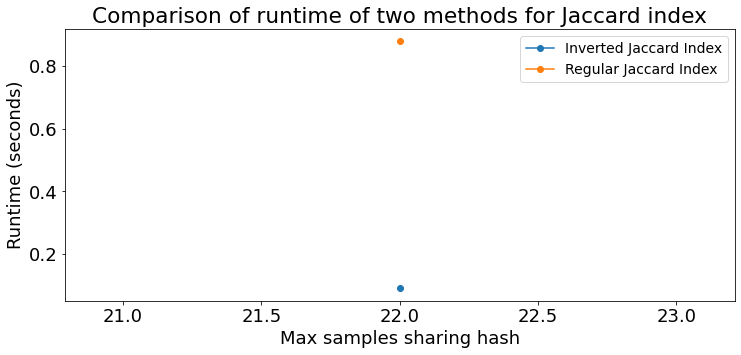

In [68]:
make_plot(plotting_label='Max samples sharing hash', constant_label='Number of Samples', constant_value=100)